In [1]:
library(SPARSim) #The SPARSim R package is loaded
library(umap)   #The umap R package is loaded
data(Zheng_param_preset)  # The Zheng dataset is loaded
test_Zheng_param_preset <- Zheng_param_preset[1:2]  #We are going to use only to conditions

In [2]:
set.seed(7)
results_Zheng <- SPARSim_simulation(dataset_parameter = test_Zheng_param_preset)  #Simulation with SPARSim

Number of experimental conditions:  2 
Number of genes:  19536 
Number of cells:  3158 
Setting gene expression intensity...  
Setting gene expression variability ...  
Simulating biological variability ...  
Simulating technical variability ...  


In [3]:
expression <- round(results_Zheng$gene_matrix*10^4)  #Real gene expression level
count <- results_Zheng$count_matrix                  #Raw data
normalization <- scran_normalization(count)          #Normalized data

In [4]:
#The UMAP dimensionality reduction is applied
umap_expression <- umap::umap(t(expression))      
umap_count <- umap::umap(t(count))
umap_normalization <- umap::umap(t(normalization))

In [5]:
#The function to plot the umap results
UMAP_plot <- function(x, labels, main="A UMAP visualization", colors=c("blue","red"),
                      pad=0.2, cex=1, pch=19, cex.main=1.5, cex.legend=2) {
  layout = x$layout
  ulabels <- unique(labels)
  names(colors) <- ulabels
  xylimit = range(layout)
  xylimit = xylimit + ((xylimit[2]-xylimit[1])*pad)*c(-0.5, 0.5)
  par(mar=c(0.2,0.7,1.2,0.7), ps=10)

  plot(xylimit, xylimit, type="n", axes=F, frame=F)
  rect(xylimit[1], xylimit[1], xylimit[2], xylimit[2], border="#aaaaaa", lwd=0.5)
  points(layout[,1], layout[,2], col=colors[labels], cex=cex, pch=pch)
  mtext(side=3, main, cex=cex.main)

  labels.u = ulabels
  legend.text = as.character(labels.u)
  legend(x = xylimit[1], y = xylimit[2], legend=legend.text, col=colors[labels.u], bty="n", pch=pch, cex=cex.legend)
}

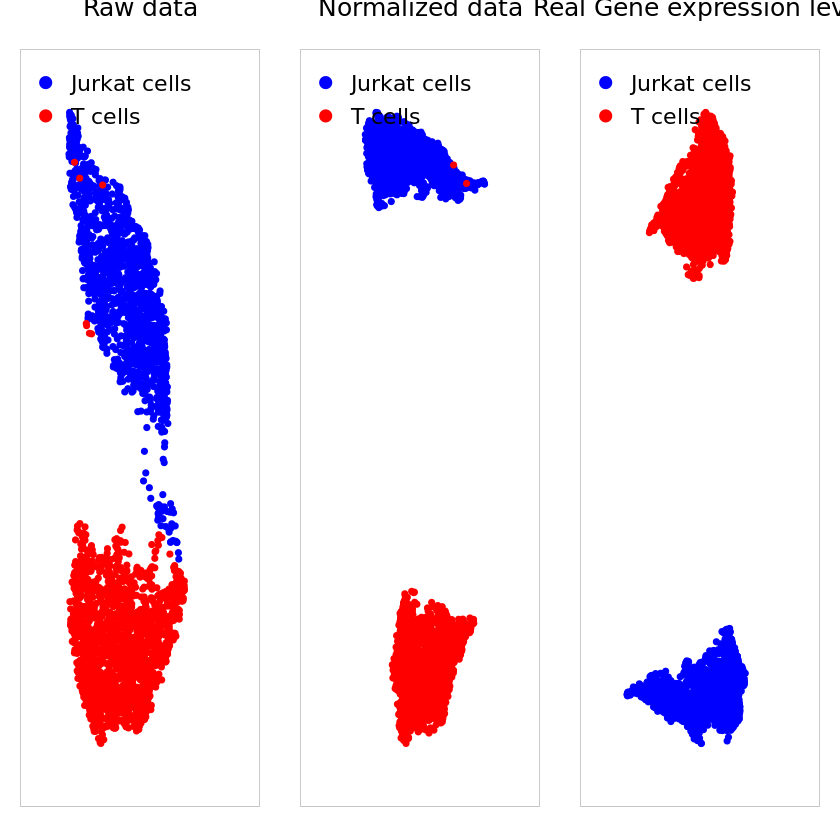

In [6]:
#Create 3 scatterplots for each dataset
par(mfrow=c(1,3))
cell_label <- c( rep("Jurkat cells", 1440) , rep("T cells", 1718))
UMAP_plot(umap_count, cell_label, main = "Raw data")
UMAP_plot(umap_normalization, cell_label, main = "Normalized data")
UMAP_plot(umap_expression, cell_label, main = "Real Gene expression level")
